# Initilisation

In [1]:
import os 
import kagglehub
import pandas as pd
import random
import cv2
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt  # Plotting library
import matplotlib.image as mpimg
import shutil


from PIL import Image

import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import transforms


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix,classification_report,roc_curve,recall_score,precision_score


from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten,Dense


Contexte :
 
On exploite ici le Dataset SMIDS, qui est un ensemble de données d’images biomédicales conçu pour l’analyse automatisée de la morphologie des spermatozoïdes humains.
Le SMIDS a été développé dans le cadre d’un système hybride de détection et de classification des spermatozoïdes basé sur MobileNet, comparé à des méthodes conventionnelles. Il permet de :​


- Détecter automatiquement les anomalies morphologiques des spermatozoïdes.

- Évaluer la concentration et la mobilité des spermatozoïdes à l’aide d’un smartphone.

- Former des modèles d’apprentissage profond pour l’analyse d’images biomédicales.

# Fonction

In [2]:
def make_df(classes,base_dir):
    data = []
    for label in classes:
        folder_path = os.path.join(base_dir, label)
        for file in os.listdir(folder_path):
            if file.endswith(('jpg','png','bmp')):  
                file_path = os.path.join(folder_path, file)
                data.append((file_path, label))
    
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

def get_image_info(path):
    try:
        with Image.open(path) as img:
            return img.size + (len(img.getbands()),)
    except:
        return (None, None, None)


def get_color_histogram(image_path, bins=32):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist = []

        for i in range(3):  # R, G, B
            h = cv2.calcHist([img], [i], None, [bins], [0, 256])
            h = cv2.normalize(h, h).flatten()
            hist.extend(h)
        return hist
    except:
        return [0] * (bins * 3)

def get_grayscale_histogram(image_path, bins=64):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # convertit directement en niveaux de gris
        hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except:
        return [0] * bins
    

In [3]:
path = kagglehub.dataset_download("orvile/sperm-morphology-image-data-set-smids")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\brude\.cache\kagglehub\datasets\orvile\sperm-morphology-image-data-set-smids\versions\1


# Exploration

In [4]:
path=path+'\\SMIDS'
classes = os.listdir(path)
print(classes)

['Abnormal_Sperm', 'Non-Sperm', 'Normal_Sperm']


3 classes différentes afin de déterminer si les spermatozoïdes sont normaux ou non

In [5]:
df = make_df(classes, path)
print("Shape of  dataset is:" ,df.shape)

Shape of  dataset is: (3000, 2)


Le Dataframe contient bien 3000 images.

In [6]:
print(df)

                                              file_path           label
0     C:\Users\brude\.cache\kagglehub\datasets\orvil...  Abnormal_Sperm
1     C:\Users\brude\.cache\kagglehub\datasets\orvil...  Abnormal_Sperm
2     C:\Users\brude\.cache\kagglehub\datasets\orvil...  Abnormal_Sperm
3     C:\Users\brude\.cache\kagglehub\datasets\orvil...  Abnormal_Sperm
4     C:\Users\brude\.cache\kagglehub\datasets\orvil...  Abnormal_Sperm
...                                                 ...             ...
2995  C:\Users\brude\.cache\kagglehub\datasets\orvil...    Normal_Sperm
2996  C:\Users\brude\.cache\kagglehub\datasets\orvil...    Normal_Sperm
2997  C:\Users\brude\.cache\kagglehub\datasets\orvil...    Normal_Sperm
2998  C:\Users\brude\.cache\kagglehub\datasets\orvil...    Normal_Sperm
2999  C:\Users\brude\.cache\kagglehub\datasets\orvil...    Normal_Sperm

[3000 rows x 2 columns]


In [7]:
df.isnull().sum()

file_path    0
label        0
dtype: int64

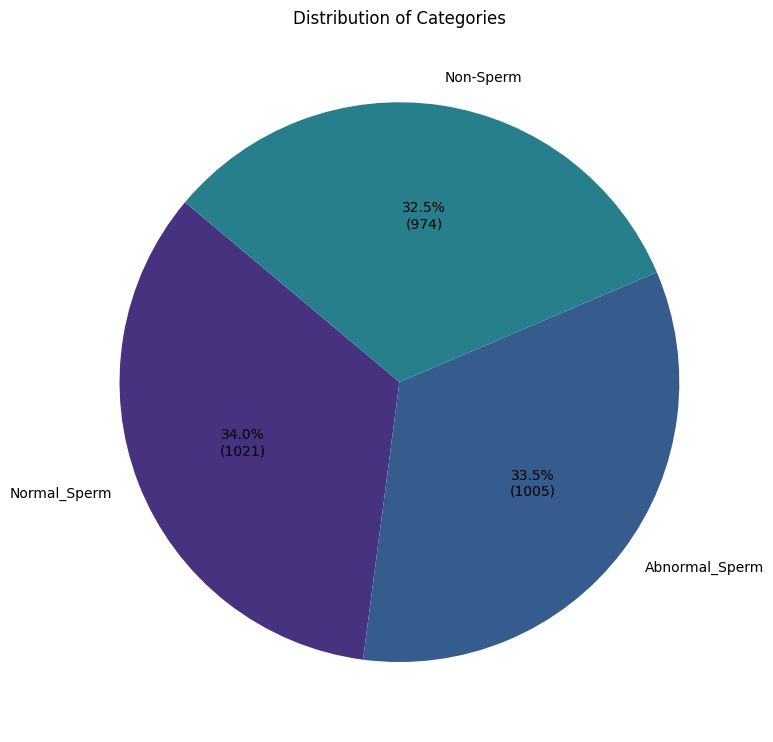

In [8]:
count = df['label'].value_counts()

palette = sns.color_palette("viridis")
colors = palette.as_hex()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, count)
    return my_autopct

plt.figure(figsize=(8, 8))
plt.pie(count, labels=count.index, autopct=make_autopct(count), startangle=140, colors=colors)

plt.title('Distribution of Categories')
plt.tight_layout()
plt.show()


On obsserve ici une répartition presque parfaite pour chaque label ~ 1 000 images.


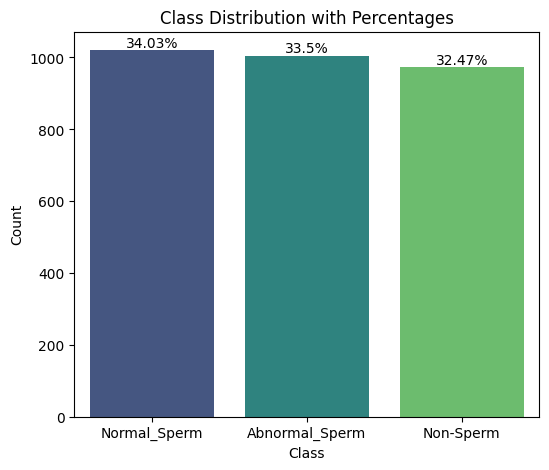

In [9]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
plt.figure(figsize=(6,5))
ax = sns.barplot(data=value_counts, x='label', y='count',
                hue='label', # Permet eà seabron de savoir que la couleur est associé aux labels.
                palette="viridis",# Choix de la palette de couleur.
                dodge=False, # Permet une plus belle mise en forme en laissant les bar assez épaisse sur le meme axe.
                legend=False) # Pas de légende car dans notre cas pas besoin, c'est déjà explicite.
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

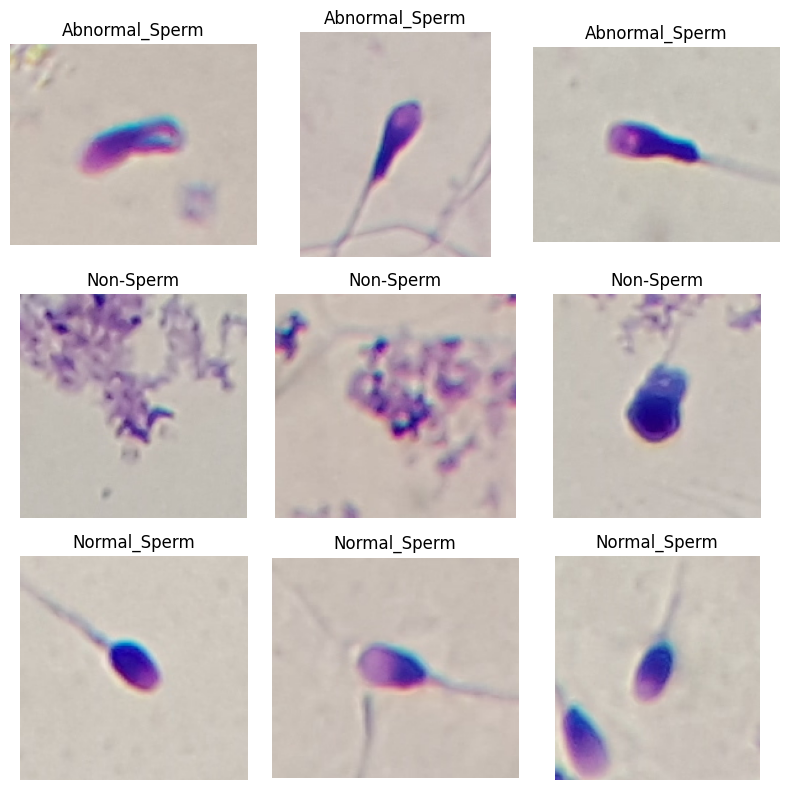

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

The dimensions of the image are 168 pixels width and 155 pixels height, with 3 color channels.
The maximum pixel value is 228.0000 and the minimum is 6.0000
The mean value of the pixels is 181.2011 and the standard deviation is 21.6775


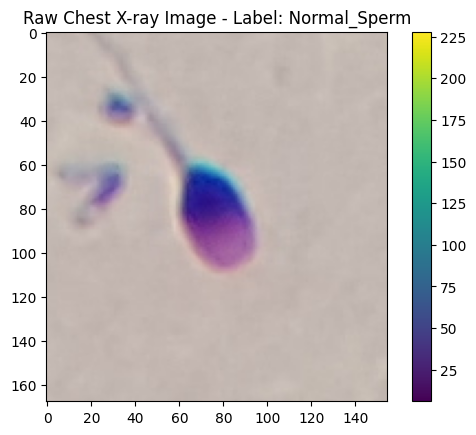

In [11]:
random_sample_row = df.sample(n=1)

image_path = random_sample_row['file_path'].values[0]
label = random_sample_row['label'].values[0]

sample_img = plt.imread(image_path)
plt.imshow(sample_img)
plt.colorbar()
plt.title(f'Raw Chest X-ray Image - Label: {label}')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, with {sample_img.shape[2]} color channels.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

### Ajout des infos des images dans le DataFrame 

In [12]:
df[['width', 'height', 'channels']] = df['file_path'].apply(lambda x: pd.Series(get_image_info(x)))
df.describe(include='all')

,file_path,label,width,height,channels
count,3000,3000,3000.000000,3000.000000,3000.0
unique,3000,3,NaN,NaN,NaN
top,C:\Users\brude\.cache\kagglehub\datasets\orvil...,Normal_Sperm,NaN,NaN,NaN
freq,1,1021,NaN,NaN,NaN
mean,NaN,NaN,171.156667,168.168000,3.0
std,NaN,NaN,18.100792,18.483569,0.0
min,NaN,NaN,122.000000,80.000000,3.0
25%,NaN,NaN,157.000000,155.000000,3.0
50%,NaN,NaN,169.000000,165.000000,3.0
75%,NaN,NaN,181.000000,178.000000,3.0


In [13]:
df['label'].value_counts(normalize=True)

label
Normal_Sperm      0.340333
Abnormal_Sperm    0.335000
Non-Sperm         0.324667
Name: proportion, dtype: float64

### PCA Sur les similitudes des couleurs du DF

<Axes: xlabel='PC1', ylabel='PC2'>

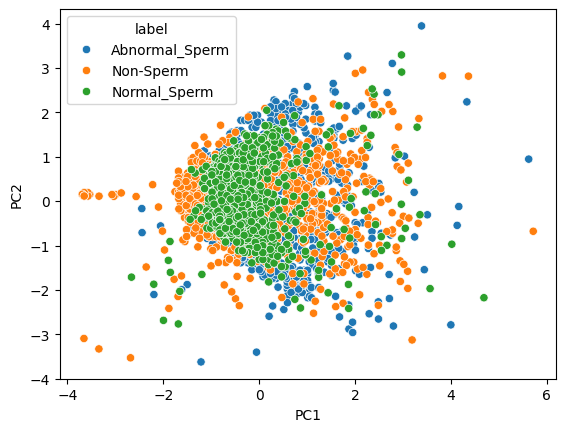

In [14]:
X = df[['width', 'height']]  # ou ajouter d'autres
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['PC1'] = components[:, 0]
df['PC2'] = components[:, 1]

sns.scatterplot(data=df, x='PC1', y='PC2', hue='label')

La taille des images ne jouent pas de role dans la finalité des spermatozoïdes.

### PCA Sur les similitudes des niveaux de gris des images

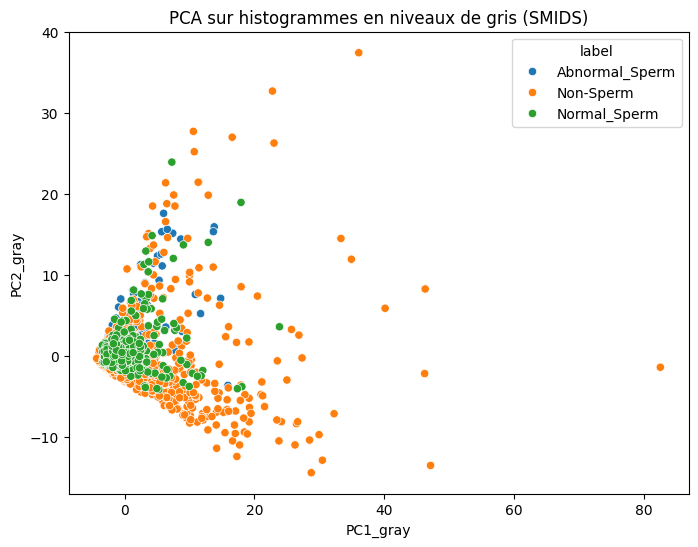

In [15]:
# Application de la fonction d'extraction des niveaux de gris 
df['gray_histogram'] = df['file_path'].apply(get_grayscale_histogram)
X_gray = np.stack(df['gray_histogram'].values)


#PCA & Normalisation
X_gray_scaled = StandardScaler().fit_transform(X_gray)

pca = PCA(n_components=2)
components = pca.fit_transform(X_gray_scaled)

df['PC1_gray'] = components[:, 0]
df['PC2_gray'] = components[:, 1]


#Visualisation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1_gray', y='PC2_gray', hue='label')
plt.title("PCA sur histogrammes en niveaux de gris (SMIDS)")
plt.show()




In [16]:

img_size = (224, 224)  # ou autre, selon le modèle

# Avec data augmentation sur le train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Sans augmentation pour validation & test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    "SMIDS_split/train", target_size=img_size, class_mode='categorical', batch_size=32)

val_generator = val_test_datagen.flow_from_directory(
    "SMIDS_split/val", target_size=img_size, class_mode='categorical', batch_size=32)

test_generator = val_test_datagen.flow_from_directory(
    "SMIDS_split/test", target_size=img_size, class_mode='categorical', batch_size=32, shuffle=False)


Found 2037 images belonging to 3 classes.
Found 511 images belonging to 3 classes.
Found 452 images belonging to 3 classes.


In [17]:

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle les poids pour le transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes !
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNetV2 est un modèle pré-entraîné sur ImageNet (1,4 million d’images, 1000 classes), connu pour être :

- Léger 

- Rapide 

- Efficace, même avec peu de données 

Il est particulièrement adapté à des cas comme SMIDS où tu as :

- Peu d’images par rapport à ImageNet

- Un besoin de bon compromis entre performance et vitesse

- Un intérêt à réutiliser des connaissances générales visuelles

In [18]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # On surveille la validation accuracy
    patience=7,               # Si l'accuracy ne s'améliore pas pendant 7 epochs, on arrête
    restore_best_weights=True,  # Restaure les meilleurs poids lorsque l'entrainement s'arrête
    verbose=1
)

# Entraînement avec plus d'epochs et Early Stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,                
    callbacks=[early_stopping]  
)


C:\Users\brude\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6618 - loss: 0.8025 - val_accuracy: 0.8121 - val_loss: 0.4708
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8114 - loss: 0.4814 - val_accuracy: 0.8023 - val_loss: 0.4616
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8231 - loss: 0.4537 - val_accuracy: 0.8219 - val_loss: 0.4329
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8286 - loss: 0.4096 - val_accuracy: 0.8004 - val_loss: 0.4474
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8344 - loss: 0.4029 - val_accuracy: 0.8317 - val_loss: 0.4367
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8548 - loss: 0.3980 - val_accuracy: 0.8317 - val_loss: 0.4163
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 871ms/step - accuracy: 0.8519 - loss: 0.3757 - val_accuracy: 0.8258 - val_loss: 0.4247
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 879ms/step - accuracy: 0.8312 - loss: 0.3813 - val_accuracy: 0.8513 - val

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 609ms/step


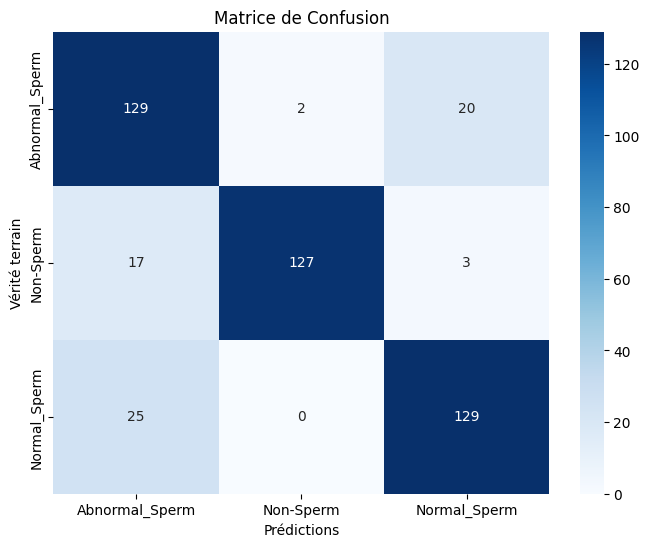

In [22]:
# Prédictions sur l'ensemble de test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Vraies classes
true_classes = test_generator.classes

# Calcul de la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)

# Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de Confusion')
plt.show()

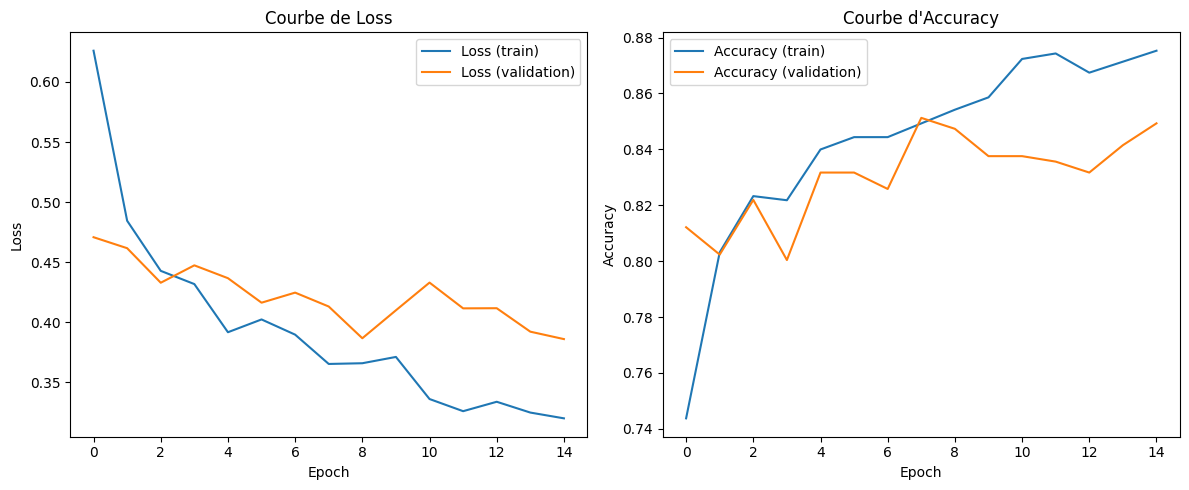

In [23]:
# Récupération des historiques d'entraînement
history_dict = history.history

# Courbes de loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Loss (train)')
plt.plot(history_dict['val_loss'], label='Loss (validation)')
plt.title('Courbe de Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Courbes d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Accuracy (train)')
plt.plot(history_dict['val_accuracy'], label='Accuracy (validation)')
plt.title('Courbe d\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
model.save("sperm_classifier.keras")